Hardware FIR execution time:  0.0030438899993896484


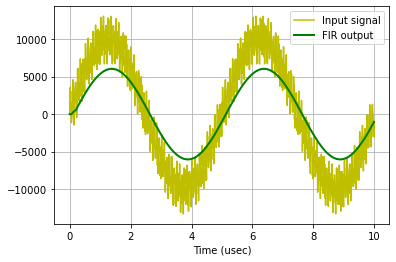

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay
import pynq.lib.dma
from pynq import allocate
import time

def plot_to_notebook(time_sec, in_signal, n_samples, out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples] * 1e6, in_signal[:n_samples], 'y-', label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples] * 1e6, out_signal[:n_samples], 'g-', linewidth=2, label='FIR output')
    plt.legend()

# FIR coefficients
coeffs = [-255, -260, -312, -288, -144, 153, 616, 1233, 1963, 2739, 3474, 4081, 
          4481, 4620, 4481, 4081, 3474, 2739, 1963, 1233, 616, 153, -144, 
          -288, -312, -260, -255]

# Signal generation
T = 0.002
fs = 100e6  # 100 MHz sampling frequency
n = int(T * fs)
t = np.linspace(0, T, n, endpoint=False)

samples = 10000 * np.sin(0.2e6 * 2 * np.pi * t) + \
          1500 * np.cos(46e6 * 2 * np.pi * t) + \
          2000 * np.sin(12e6 * 2 * np.pi * t)

samples = samples.astype(np.int32)

# Load the FPGA overlay
overlay = Overlay('fir.bit')
dma = overlay.filter.fir_dma

# Allocate buffers for input and output signals
with allocate(shape=(n,), dtype=np.int32) as in_buffer, \
     allocate(shape=(n,), dtype=np.int32) as out_buffer:

    # Copy the samples to the input buffer
    np.copyto(in_buffer, samples)

    # Trigger the DMA transfer and wait for the result
    start_time = time.time()
    
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    
    dma.sendchannel.wait()
    dma.recvchannel.wait()

    stop_time = time.time()
    hw_exec_time = stop_time - start_time

    print('Hardware FIR execution time: ', hw_exec_time)

    # Plot the result
    plot_to_notebook(t, samples, 1000, out_signal=out_buffer)
    plt.show()

    # Free the buffers
    in_buffer.close()
    out_buffer.close()
